In [1]:
!pip install netCDF4
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 51.9 MB/s eta 0:00:00


In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
#import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import regularizers

In [8]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00


In [9]:
from sklearn_extra.cluster import KMedoids

In [3]:
#MOUNT DATA
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

path = '/content/drive/MyDrive/Colab_Notebooks/Project/'
pathOLCI = '/content/drive/MyDrive/Colab_Notebooks/Project/OLCI/'
pathSAR = '/content/drive/MyDrive/Colab_Notebooks/Project/SAR_analysis/'
file = 'S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002/S3A_OL_1_EFR____20180607T073416_20180607T073716_20180608T112912_0179_032_092_1620_LN1_O_NT_002.SEN3'

Mounted at /content/drive


In [5]:
with open(path+'SAR_analysis/select_files.txt') as f: # In select_files.txt, you should put the file name of the OLCI image that you want to overlay the track on
    selects = [line.rstrip('\n') for line in open(path+'SAR_analysis/select_files.txt')]

#with open('/Volumes/OLCI/selects/matching_SAR_tracks.txt') as f:
with open(path+'SAR_analysis/matching_SAR_tracks.txt') as f: # In marching_SAR_tracks.txt, you should put the corresponding GPOD files that contains the track information
    matching_SAR_list = [line.rstrip('\n') for line in open(path+'SAR_analysis/matching_SAR_tracks.txt')]

# Select radiance band:
Radiance=1
R=str("%02d" % Radiance) #defines R as string 0,1 in order to fit it into the file

#if len(selects)[0:1] is =1 make j=0
#for file in selects
j=-1

for file in selects[1:2]:
    j = 0
    j=j+1

#trying to match Sentinel-3 with OLCI files

    startindex=(file.index('S3A_OL_1_EFR_'))
#    OLCI_file='/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/'+file[startindex:-9]
#    OLCI_file='/Volumes/OLCI/'+file[startindex:-9]
    OLCI_file=file[startindex:-4]
    print(OLCI_file)
#     tif_file=OLCI_file+'/true_color.tif'

    geo_coords=Dataset(pathOLCI + OLCI_file+'_002.SEN3'+'/geo_coordinates.nc') #+'_002.SEN3'+'/'+ OLCI_file+'_002.SEN3'
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]

#load radiances --> for only one radiance in this case
#dataset is a command that allows you to read nc files
    OLCI_data=Dataset(pathOLCI +OLCI_file+'_002.SEN3'+'/Oa'+R+'_radiance.nc')

    print(OLCI_lon.shape)
    OLCI_data=np.asarray(OLCI_data['Oa'+R+'_radiance'])
    #end up with an array of all the data from OLCI
    OLCI_data[OLCI_data==65535]=np.nan #did a bit of masking here

    #remove nan columns

    #Create a sample 2D array with NaN values

    # Remove columns with NaN values
    OLCI_lon_orig = OLCI_lon[:, ~np.isnan(OLCI_data).any(axis=0)]
    OLCI_lat_orig = OLCI_lat[:, ~np.isnan(OLCI_data).any(axis=0)]
    OLCI_data = OLCI_data[:, ~np.isnan(OLCI_data).any(axis=0)]




    print(OLCI_data.shape)
    print(OLCI_lon_orig.shape)
    print(OLCI_lat_orig.shape)


S3A_OL_1_EFR____20180609T095753_20180609T100053_20180610T150459_0179_032_122_1260_LN1_O_NT
(4091, 4865)
(4091, 4714)
(4091, 4714)
(4091, 4714)


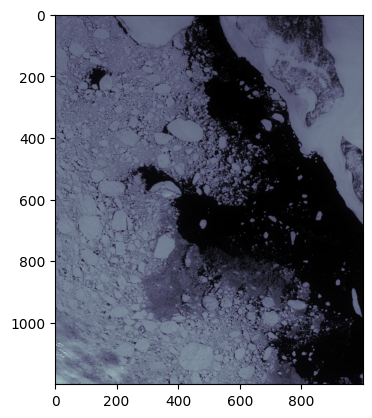

In [6]:
OLCI_data_zoom = OLCI_data[1000:2200,2500:3500]
plt.imshow(OLCI_data_zoom,cmap='bone')

In [ ]:
# Assuming OLCI_data has shape (4091, 4714)
OLCI_data_zoom = OLCI_data[1000:2200,2500:3500]
scaler = StandardScaler()
data_normalized = scaler.fit_transform(OLCI_data_zoom)
data_normalized = data_normalized.reshape(-1, 1)

n = 10
# Apply Kmedoids
kmedoids = KMedoids(n_clusters=n, random_state=0)

kmedoids.fit(data_normalized)
# Get cluster centroids and labels
clusters = kmedoids.labels_

'''
# Apply K-means clustering
n=10
kmeans = KMeans(n_clusters=n, random_state=0)
# Fit the model and predict cluster labels for each data point
clusters_kmeans = kmeans.fit_predict(data_normalized)
'''
cmap = plt.cm.get_cmap('bone', n)

# Reshape clusters_kmeans to match the shape of OLCI_data
clusters = clusters.reshape(OLCI_data_zoom.shape[0], -1)

print(clusters.shape)


(-0.5, 999.5, 1199.5, -0.5)

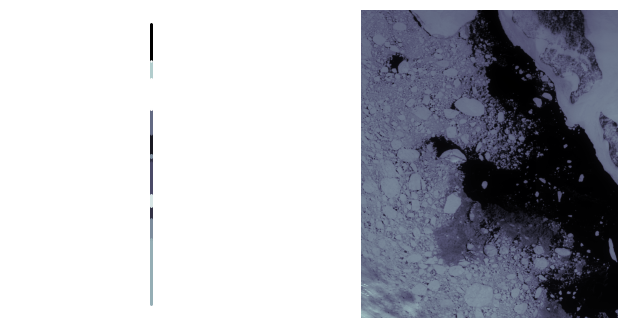

In [12]:
plt.figure(figsize=(8,4))
plt.subplot(121)
for i in range(n):
  class_indices = np.where(clusters == i)[0]
  plt.scatter(np.where(clusters==i)[1],-np.where(clusters==i)[0], c=[cmap(i)], label=f'Class {i}',s=0.4)
  plt.axis('off')

plt.subplot(122)
plt.imshow(OLCI_data_zoom,cmap = 'bone')
plt.axis('off')

(-0.5, 4713.5, 4090.5, -0.5)

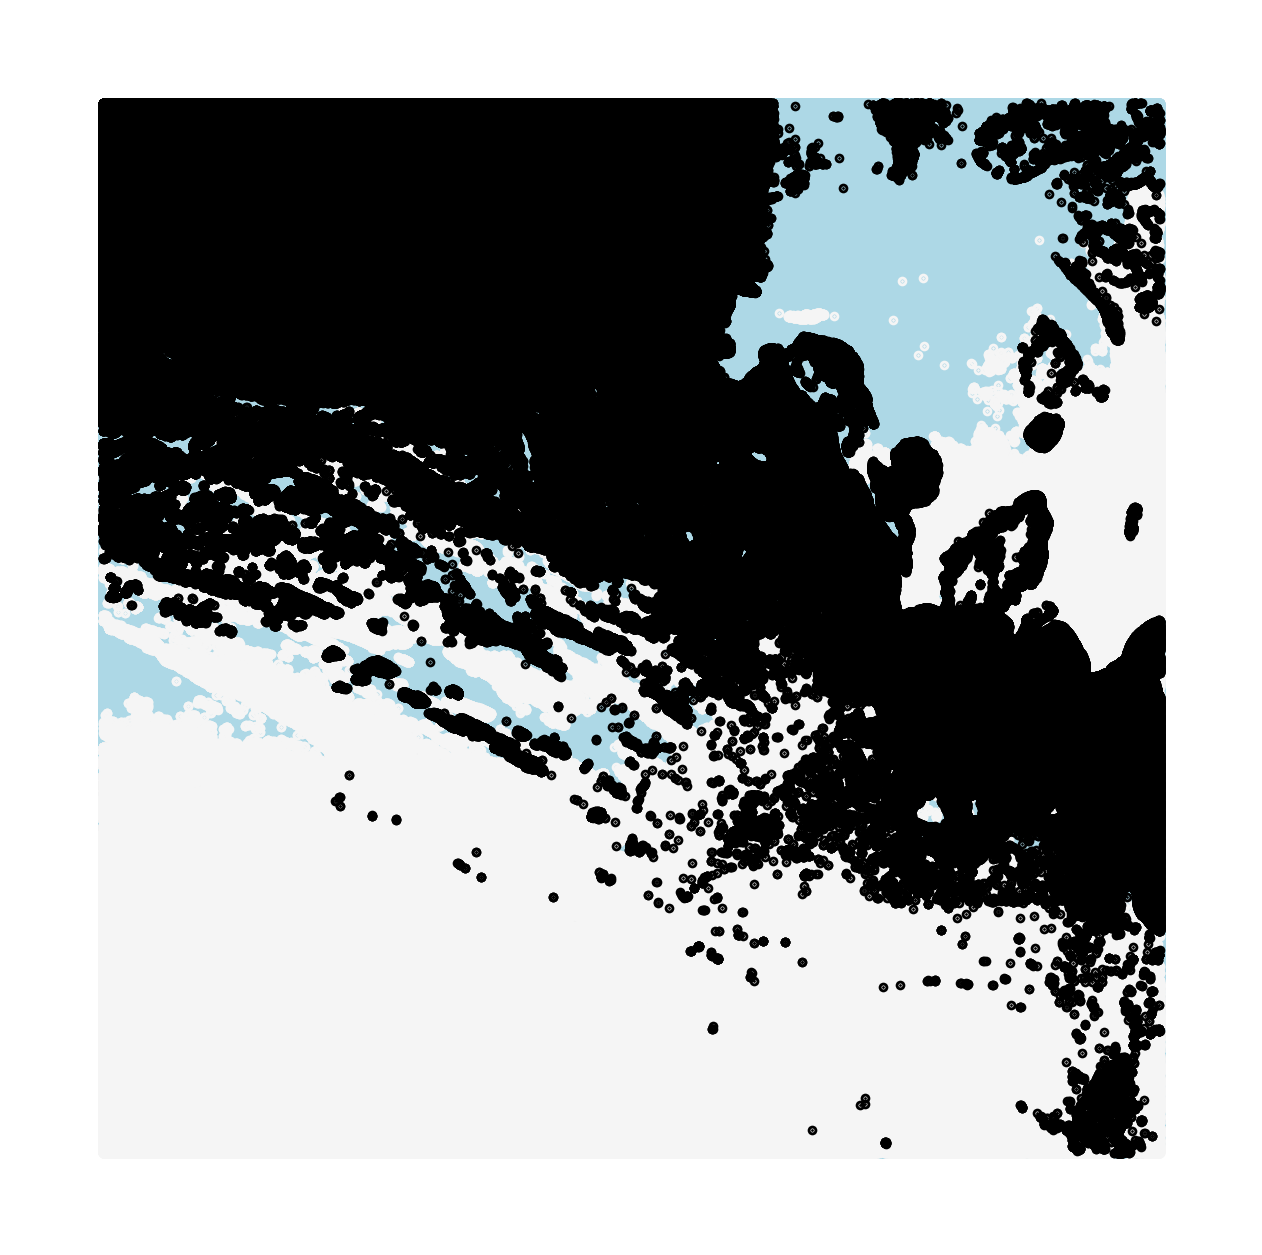

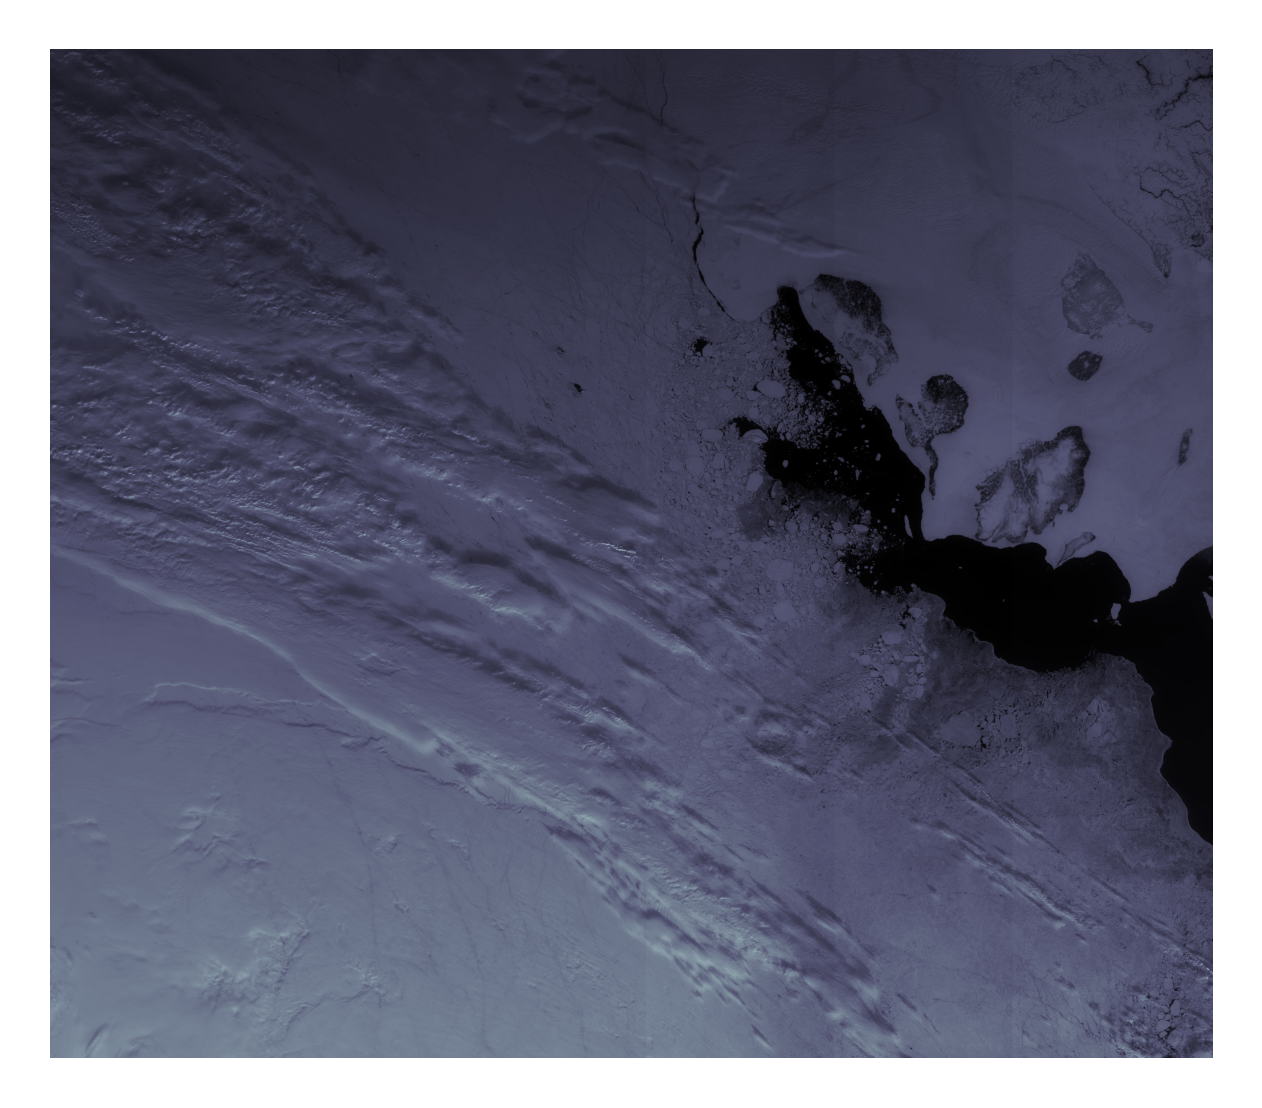

In [ ]:
plt.figure(figsize=(3,3),dpi=500)
plt.plot(np.where(clusters_kmeans==0)[1],-np.where(clusters_kmeans==0)[0],'o',color='lightblue',ms=0.4,linewidth=0)
plt.plot(np.where(clusters_kmeans==1)[1],-np.where(clusters_kmeans==1)[0],'o',color='whitesmoke',ms=0.4,linewidth=0)
plt.plot(np.where(clusters_kmeans==2)[1],-np.where(clusters_kmeans==2)[0],'o',color='black',ms=0.4,linewidth=0)
plt.plot(np.where(clusters_kmeans==3)[1],-np.where(clusters_kmeans==3)[0],'o',color='lightskyblue',ms=0.4,linewidth=0)
plt.axis('off')
plt.figure(figsize=(3,3),dpi = 500)
plt.imshow(OLCI_data,cmap='bone')
plt.axis("off")
#plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Project/OLCI_analysis/classify_maps/test',dpi=400)

In [ ]:
print(OLCI_lon_orig.shape)
print(OLCI_lat_orig[:,6])

(4091, 4714)
[74.840451 74.843003 74.845555 ... 85.264399 85.266948 85.269496]


In [ ]:
OLCI_centre_lat = OLCI_lat_orig[OLCI_lat_orig.shape[0]//2,OLCI_lat_orig.shape[1]//2]
OLCI_centre_lon = OLCI_lat_orig[OLCI_lon_orig.shape[0]//2,OLCI_lon_orig.shape[1]//2]
OLCI_lat = OLCI_lat_orig.ravel()
OLCI_lon = OLCI_lon_orig.ravel()
OLCI_data_flat = OLCI_data.ravel()

w = OLCI_lon_orig.shape[1]
plt.figure(figsize=(30,30),dpi=400)
m = Basemap(resolution='l',projection='laea',ellps='WGS84', lat_ts=0,  lat_0= OLCI_centre_lat, lon_0=OLCI_centre_lon, width=w,height=w)

OLCI_x,OLCI_y=m(OLCI_lon,OLCI_lat)
#OLCI_data.reshape(OLCI_x.shape[0],OLCI_y.shape[1])
m.scatter(OLCI_x,OLCI_y,c=OLCI_data_flat,s=60,marker='o',cmap='bone')
plt.title("OLCI_map_test")
plt.clf()
print("done")

(19284974,) (19284974,)
done


<Figure size 12000x12000 with 0 Axes>